In [55]:
!pip install pycocotools

In [56]:
import torch
import torchvision
from torchvision.models.detection import KeypointRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO

In [57]:

COCO_DIR = "/kaggle/input/coco-2017-dataset/coco2017"
TRAIN_IMG_DIR = os.path.join(COCO_DIR, "train2017")
VAL_IMG_DIR = os.path.join(COCO_DIR, "val2017")
TRAIN_ANN_FILE = os.path.join(COCO_DIR, "annotations/person_keypoints_train2017.json")
VAL_ANN_FILE = os.path.join(COCO_DIR, "annotations/person_keypoints_val2017.json")

# Training parameters
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_EPOCHS = 5

In [58]:
class CocoKeypointDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transform = transform
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.category_ids = self.coco.getCatIds(catNms=['person'])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        

        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = img.astype(np.float32) / 255.0


        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids)
        annotations = self.coco.loadAnns(ann_ids)

        boxes = []
        keypoints = []
        for ann in annotations:
            if ann['num_keypoints'] > 0:

                kpts = np.array(ann['keypoints'], dtype=np.float32).reshape(-1, 3)
                

                kpts[:, 0] *= IMAGE_SIZE / img_info['width']
                kpts[:, 1] *= IMAGE_SIZE / img_info['height']
                

                kpts[:, 2] = (kpts[:, 2] > 0).astype(np.float32)
                
                keypoints.append(torch.tensor(kpts))


                bbox = ann['bbox']
                x1 = bbox[0] * IMAGE_SIZE / img_info['width']
                y1 = bbox[1] * IMAGE_SIZE / img_info['height']
                x2 = (bbox[0] + bbox[2]) * IMAGE_SIZE / img_info['width']
                y2 = (bbox[1] + bbox[3]) * IMAGE_SIZE / img_info['height']
                boxes.append([x1, y1, x2, y2])

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4)),
            'keypoints': torch.stack(keypoints) if keypoints else torch.zeros((0, 17, 3)),
            'labels': torch.ones((len(boxes),), dtype=torch.int64),
            'image_id': torch.tensor([img_id])
        }


        if self.transform:
            img = self.transform(img)  # transforms.ToTensor() handles conversion
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()

        return img, target

In [59]:
# =============================================
# 3. Data Loading
# =============================================
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = CocoKeypointDataset(TRAIN_IMG_DIR, TRAIN_ANN_FILE, transform)
val_dataset = CocoKeypointDataset(VAL_IMG_DIR, VAL_ANN_FILE, transform)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

loading annotations into memory...
Done (t=7.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [60]:
# =============================================
# 4. Model Definition (Keypoint RCNN)
# =============================================
def create_model():
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    return KeypointRCNN(
        backbone,
        num_classes=2,  # background + person
        num_keypoints=17,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=roi_pooler
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model().to(device)

In [61]:

# =============================================
# 5. Training Setup
# =============================================
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

In [62]:
# =============================================
# 6. Training Loop (Modified for 200 batches/epoch)
# =============================================
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    processed_batches = 0  
    

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Stop after 200 batches
        if batch_idx >= 500:
            break
            
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        processed_batches += 1
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Batch {batch_idx} | Loss: {losses.item():.2f}")


    avg_loss = total_loss / processed_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.2f}")

Starting training...
Epoch 1/5 | Batch 0 | Loss: 8.08
Epoch 1/5 | Batch 50 | Loss: 6.41
Epoch 1/5 | Batch 100 | Loss: 6.45
Epoch 1/5 | Batch 150 | Loss: 5.93
Epoch 1/5 | Batch 200 | Loss: 7.11
Epoch 1/5 | Batch 250 | Loss: 6.53
Epoch 1/5 | Batch 300 | Loss: 6.19
Epoch 1/5 | Batch 350 | Loss: 5.98
Epoch 1/5 | Batch 400 | Loss: 5.62
Epoch 1/5 | Batch 450 | Loss: 6.59
Epoch 1 Average Loss: 5.83
Epoch 2/5 | Batch 0 | Loss: 5.91
Epoch 2/5 | Batch 50 | Loss: 0.04
Epoch 2/5 | Batch 100 | Loss: 6.27
Epoch 2/5 | Batch 150 | Loss: 5.94
Epoch 2/5 | Batch 200 | Loss: 5.52
Epoch 2/5 | Batch 250 | Loss: 6.23
Epoch 2/5 | Batch 300 | Loss: 0.04
Epoch 2/5 | Batch 350 | Loss: 5.95
Epoch 2/5 | Batch 400 | Loss: 6.68
Epoch 2/5 | Batch 450 | Loss: 6.06
Epoch 2 Average Loss: 5.37
Epoch 3/5 | Batch 0 | Loss: 5.22
Epoch 3/5 | Batch 50 | Loss: 5.51
Epoch 3/5 | Batch 100 | Loss: 0.03
Epoch 3/5 | Batch 150 | Loss: 6.67
Epoch 3/5 | Batch 200 | Loss: 4.92
Epoch 3/5 | Batch 250 | Loss: 4.77
Epoch 3/5 | Batch 300 | 

In [64]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, file_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Return the image and its file name for possible logging
        return image, file_name


In [65]:
import torchvision


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [66]:
from torch.utils.data import DataLoader

TEST_IMG_DIR = "/kaggle/input/testing2/DO"  # Update this path to your test dataset folder
test_dataset = TestDataset(TEST_IMG_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Processing: human.jpeg


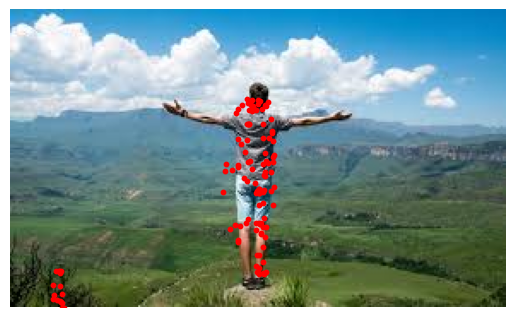

Processing: r1.jpg


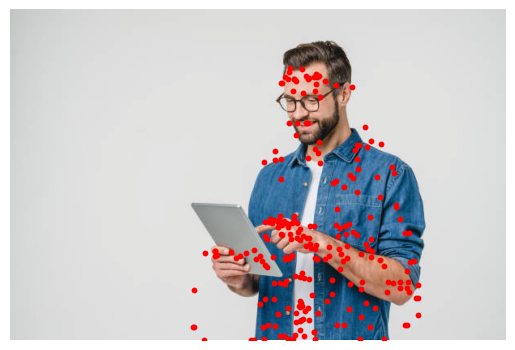

Processing: s3.jpg


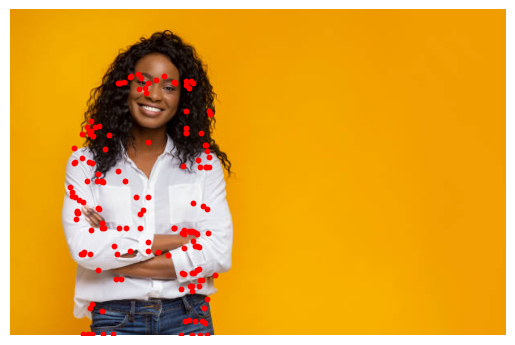

Processing: s4.jpg


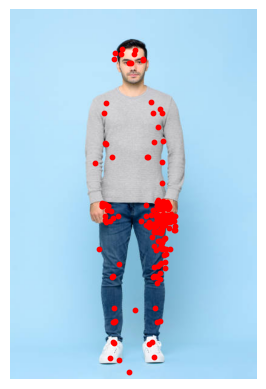

In [67]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(image, prediction):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = image.cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)


    for kps in prediction['keypoints']:
        for kp in kps:
            x, y, conf = kp
            if conf > 0.5:
                plt.scatter(x.cpu(), y.cpu(), c='red', s=10)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():

    for images, file_names in test_loader:

        images = [img.to(device) for img in images]

        predictions = model(images)

        for img, pred, fname in zip(images, predictions, file_names):
            print("Processing:", fname)
            visualize_predictions(img.cpu(), pred)
